In [1]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [3]:
import shap
import joblib
import pickle
shap.initjs()

c:\Users\dell\anaconda3\envs\reg_forest\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\dell\anaconda3\envs\reg_forest\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_orde

In [4]:
from econml.grf import RegressionForest

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import joblib
import textwrap
from importlib.machinery import SourceFileLoader

In [6]:
fun = SourceFileLoader( 'funciones', r'..\..\..\code\modules\funciones.py' ).load_module()
vn  = SourceFileLoader( 'variables_nombres', r'..\..\..\code\modules\variables_nombres.py' ).load_module()

# 1. Grid Search Plots

### 1.1. Intense Corruption

We select the best performing model (Random Forest ST) and get the grid search results

In [12]:
df_gs_ci = pd.read_excel( r'..\..\..\output\ejecucion_10\gridsearch_results\gs_ci_Random Forest Classifier_s.xlsx')

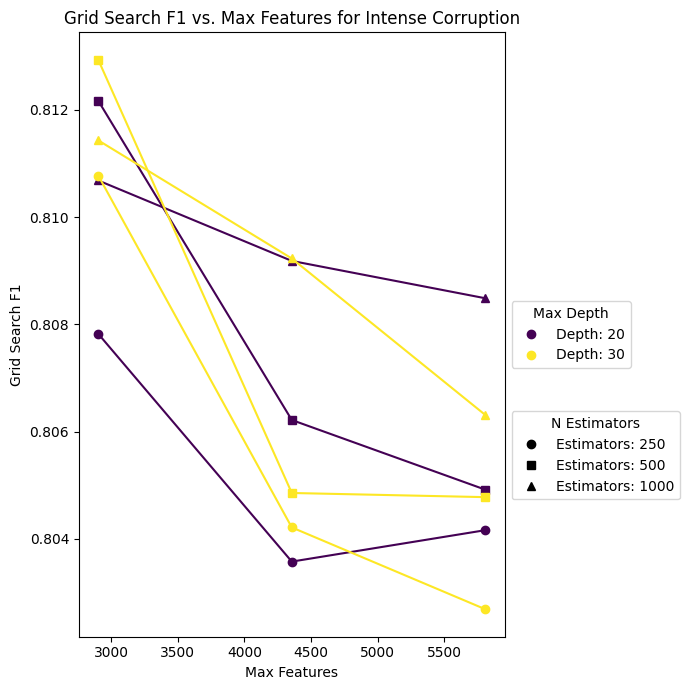

In [15]:
# Definir colores y marcadores únicos
depth_colors = {depth: color for depth, color in zip(sorted(df_gs_ci['param_max_depth'].unique()), plt.cm.viridis(np.linspace(0, 1, len(df_gs_ci['param_max_depth'].unique()))))}
estimators_markers = {est: marker for est, marker in zip(sorted(df_gs_ci['param_n_estimators'].unique()), ['o', 's', '^', 'd', '*', 'P', 'X'])}

plt.figure(figsize=(7, 7))

# Iterar sobre cada combinación de 'max_depth' y 'n_estimators' y graficar
for (max_depth, n_estimators), group_data in df_gs_ci.groupby(['param_max_depth', 'param_n_estimators']):
    sorted_group_data = group_data.sort_values('param_max_features')
    plt.plot(sorted_group_data['param_max_features'], sorted_group_data['mean_test_score'],
             color=depth_colors[max_depth], marker=estimators_markers[n_estimators], linestyle='-')

# Crear leyendas
# Leyenda para max_depth (color)
depth_legend = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', label=f'Depth: {depth}')
                for depth, color in depth_colors.items()]

# Leyenda para n_estimators (marcador)
estimators_legend = [mlines.Line2D([], [], color='black', marker=marker, linestyle='None', label=f'Estimators: {est}')
                     for est, marker in estimators_markers.items()]

# Agregar leyendas al gráfico
legend_depth = plt.legend(handles=depth_legend, title='Max Depth', loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
plt.gca().add_artist(legend_depth)
plt.legend(handles=estimators_legend, title='N Estimators', loc='center left', bbox_to_anchor=(1, 0.3), frameon=True)

# Configurar gráfico
plt.xlabel('Max Features')
plt.ylabel('Grid Search F1')
plt.title('Grid Search F1 vs. Max Features for Intense Corruption')
plt.tight_layout()
plt.savefig(r'..\..\..\output\ejecucion_10\plots\ci_rf_s.png', bbox_inches='tight')
plt.show()

### 1.2. Broad Corruption

In [7]:
df_gs_ca = pd.read_excel( r'..\..\..\output\ejecucion_10\gridsearch_results\gs_ca_Regression Forest_nro.xlsx')

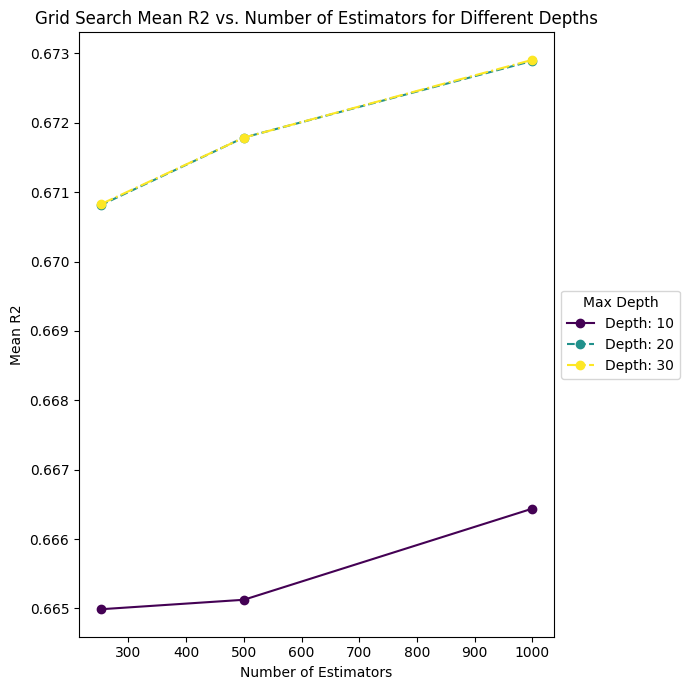

In [10]:
# Definir colores y marcadores únicos
depth_colors = {depth: color for depth, color in zip(sorted(df_gs_ca['param_max_depth'].unique()), plt.cm.viridis(np.linspace(0, 1, len(df_gs_ca['param_max_depth'].unique()))))}

plt.figure(figsize=(7, 7))

line_styles = ['-', '--', '-.', ':']
for i, max_depth in enumerate(sorted(df_gs_ca['param_max_depth'].unique())):
    filtered_data = df_gs_ca[df_gs_ca['param_max_depth'] == max_depth]
    plt.plot(filtered_data['param_n_estimators'], filtered_data['mean_test_score'],
             label=f'Depth: {max_depth}', marker='o', linestyle=line_styles[i % len(line_styles)], color=depth_colors[max_depth])

# Configurar el gráfico
plt.xlabel('Number of Estimators')
plt.ylabel('Mean R2')
plt.title('Grid Search Mean R2 vs. Number of Estimators for Different Depths')
plt.legend(title='Max Depth', loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

plt.tight_layout()
# Descomenta la siguiente línea para guardar la figura en tu sistema de archivos
plt.savefig(r'..\..\..\output\ejecucion_10\plots\ca_regf_nro.png', bbox_inches='tight')
# plt.show()


# 2. Canon Correlation Plots

## 2.1. Intense Corruption

### 2.1.1. Gini Criteria

In [40]:
path = r'..\..\..\input\preprocessed_data\base0.csv'
data = pd.read_csv( path )

In [41]:
data = data.rename( columns = { 'totaldev_canon'  : 'Canon: Total devengado', 
                                '_totaldev_canon' : 'Canon: Total devengado rezagado',
                                'totaldev_canonpc': 'Canon: Total devengado per cápita',
                                'totaleje_canon'  : 'Canon: Total ejecutado',
                                '_totaleje_canon' : 'Canon: Total ejecutado rezagado',
                                'totaleje_canonpc': 'Canon: Total ejecutado per cápita',
                                'pim_canon'       : 'Canon: PIM',
                                '_pim_canon': 'Canon: PIM rezagado',
                                'pim_canonpc': 'Canon: PIM per cápita' } )


variable_labels = {
    "_tejgfun_f5ct06amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función Ambiente",
    "_tejgtotfun_f5r18amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "_tejgfun_f5ct06ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función Ambiente",
    "_tejgtotfun_f5amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función Ambiente",
    "devppimtotfun_f5r18opseg": "Porcentaje Devengado del PIM de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Orden Público y Seguridad",
    "_tejgtotfun_f5r18ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 para la Función Ambiente",
    "_tejgtotfun_f5r08pgrco": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Función Planeamiento, Gestión y Reserva de Contingencia",
    "_tejgge_r08ct05biser": "Total Ejecutado rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "_tejgrb_impm": "Total Ejecutado rezagado en el Rubro de Impuestos Municipales",
    "empinc_7": "La municipalidad realizó acciones realizadas en promoción de MYPES/educación financiera (dicotómica)",
    "tejgfun_f5ct05prots": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "_tejgfun_f5r18ct05pgrco": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "tejgtotfun_f5r07ambpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal), para la Función Ambiente",
    "empinc_4": "La municipalidad realizó acciones realizadas en promoción de MYPES/convenios con ONGs, empresas privadas (dicotómica)",
    "tejgtotfun_f5r18ambpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "_tejgct_r08gstcr": "Total Ejecutado rezagado en la Categoría de Gastos Corrientes del Rubro 08 (Impuestos Municipales)",
    "_tejgtotfun_f5r07amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Función Ambiente",
    "tejgtotfun_f5r18amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "tejgtotfun_f5r07amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Función Ambiente",
    "_tejgge_r09ct05biser": "Total Ejecutado rezagado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios"
}


most_important_vars_ci = [
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función Ambiente",
    "Porcentaje Devengado del PIM de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Orden Público y Seguridad",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 para la Función Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Función Planeamiento, Gestión y Reserva de Contingencia",
    "Total Ejecutado rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "Total Ejecutado rezagado en el Rubro de Impuestos Municipales",
    "La municipalidad realizó acciones realizadas en promoción de MYPES/educación financiera (dicotómica)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal), para la Función Ambiente",
    "La municipalidad realizó acciones realizadas en promoción de MYPES/convenios con ONGs, empresas privadas (dicotómica)",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "Total Ejecutado rezagado en la Categoría de Gastos Corrientes del Rubro 08 (Impuestos Municipales)",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Función Ambiente",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Función Ambiente",
    "Total Ejecutado rezagado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios"
]


data = data.rename(columns={var: variable_labels[var] for var in data.columns if var in variable_labels})

canon_vars          = [ 'Canon: Total devengado', 'Canon: Total devengado rezagado', 'Canon: Total devengado per cápita', 
                        'Canon: Total ejecutado', 'Canon: Total ejecutado rezagado', 'Canon: Total ejecutado per cápita',
                        'Canon: PIM', 'Canon: PIM rezagado', 'Canon: PIM per cápita' ]

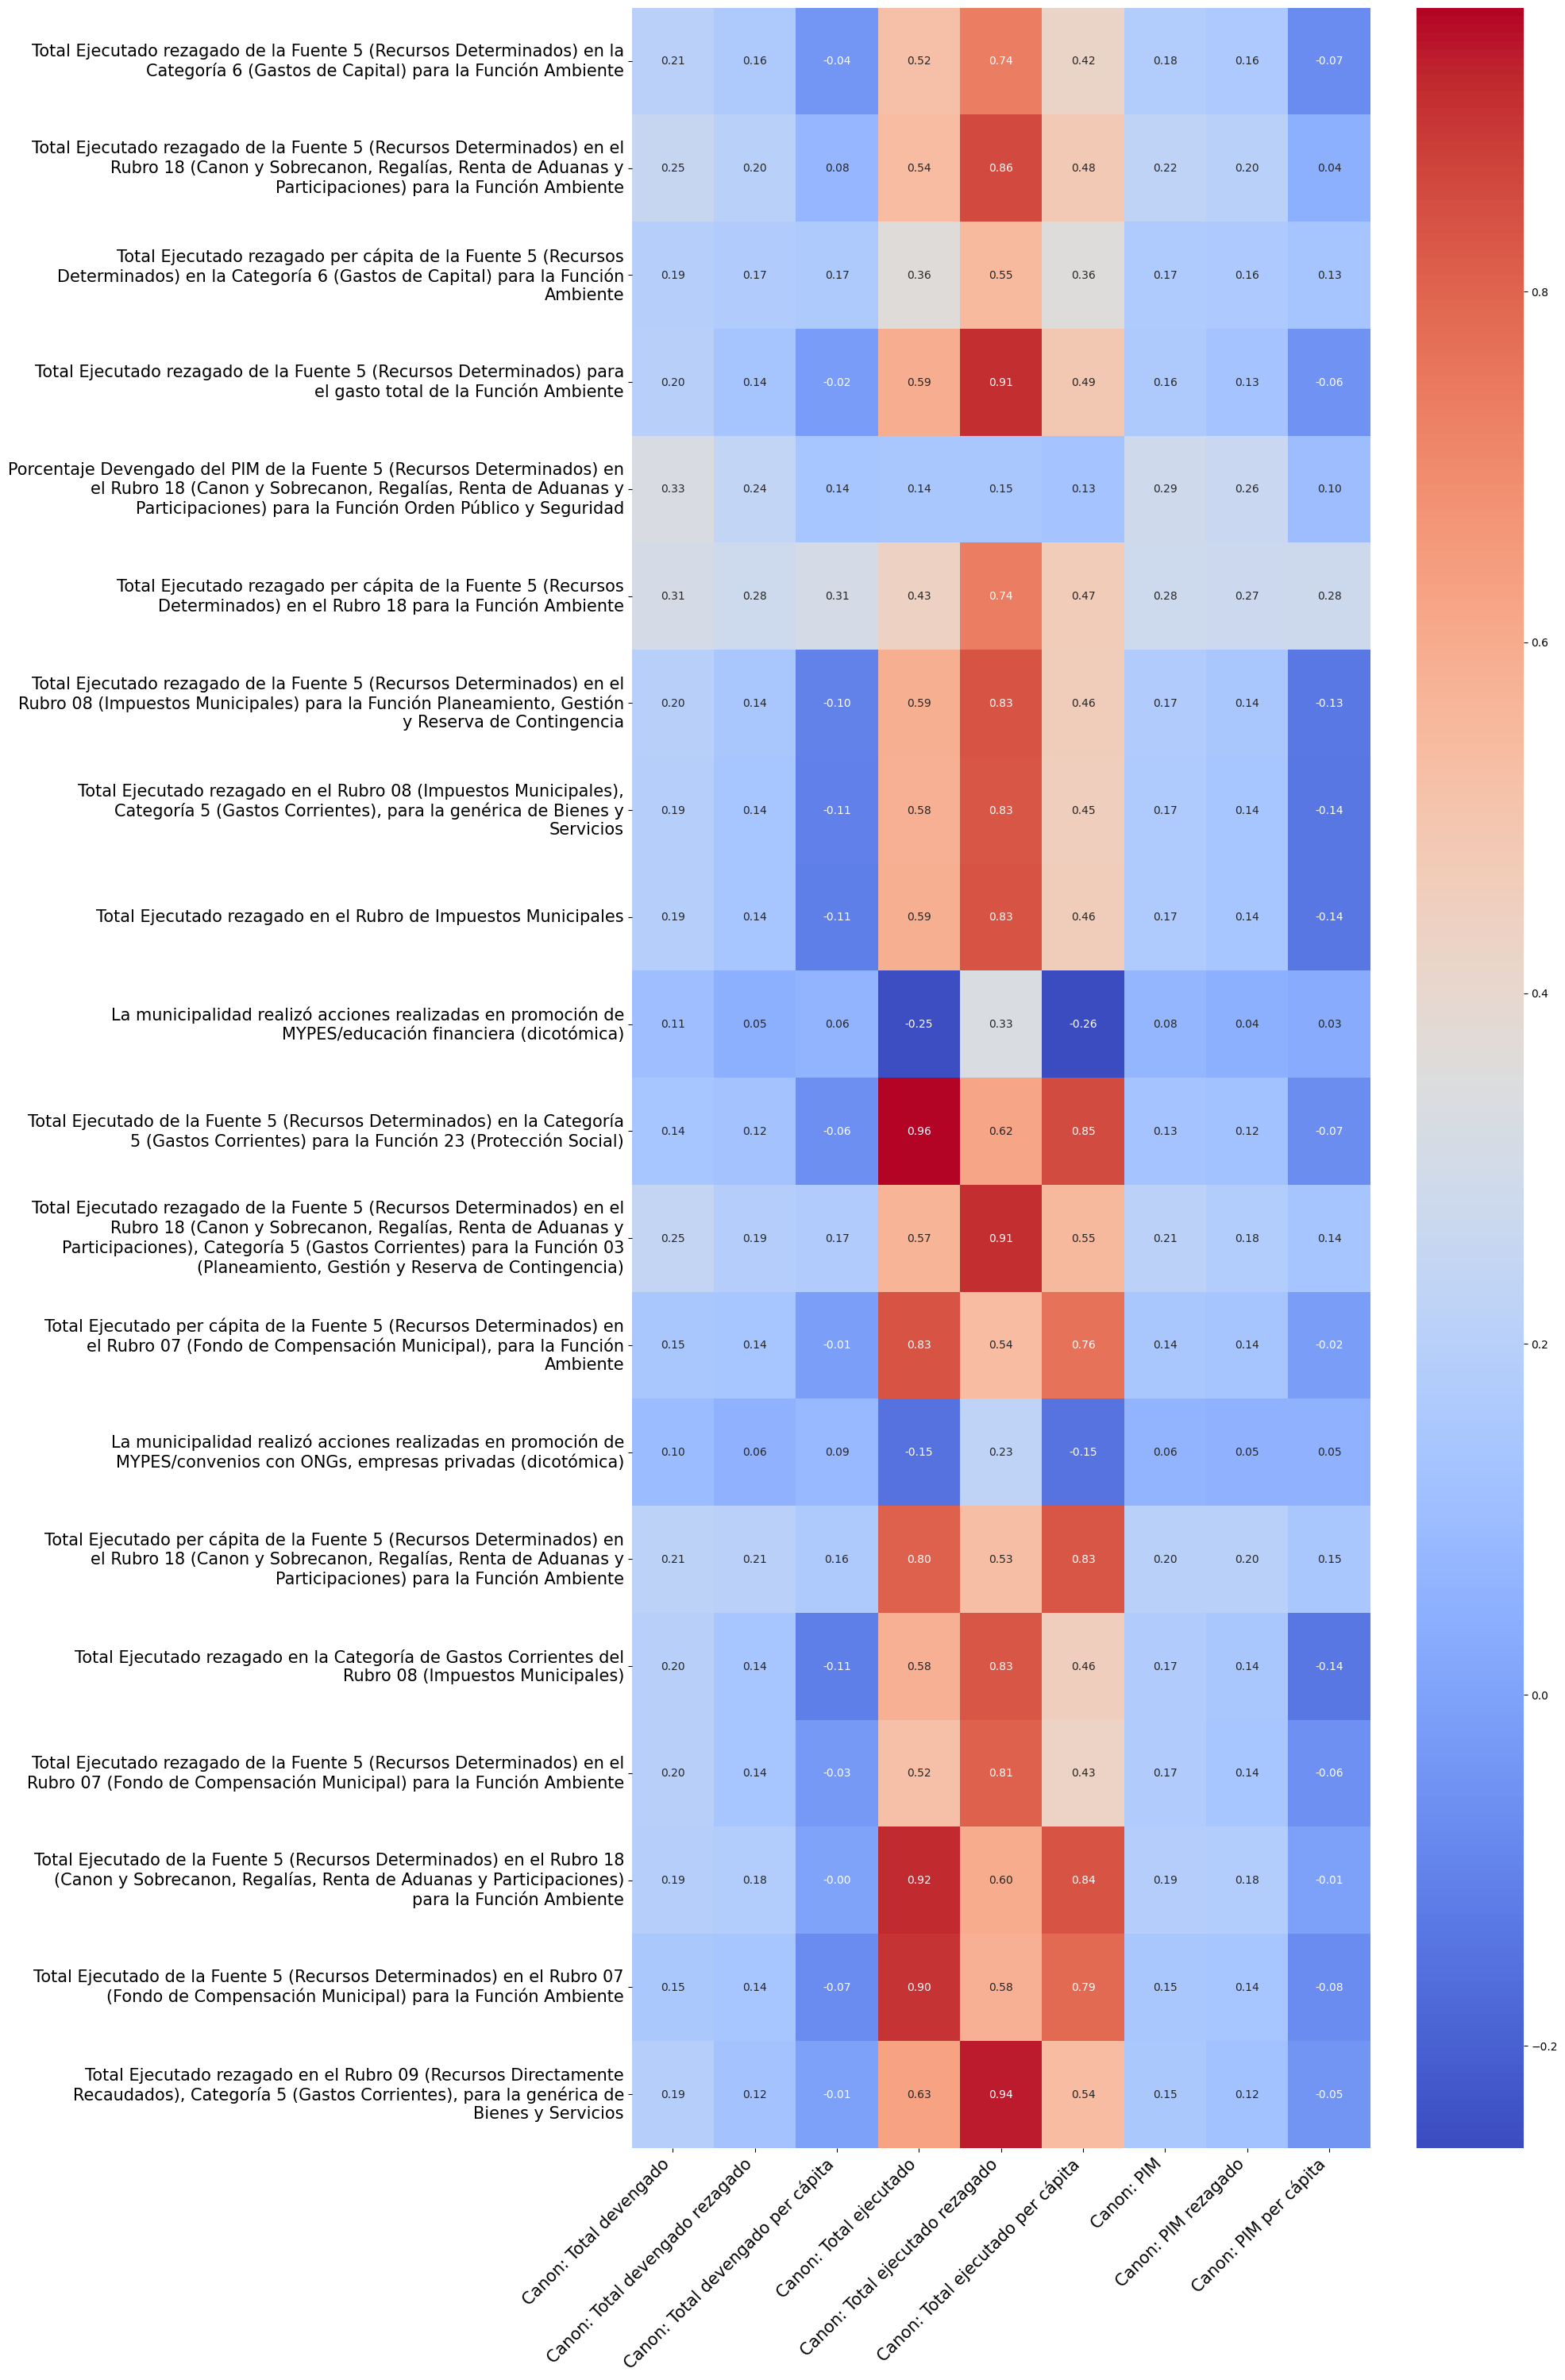

In [42]:
# Asumiendo que data es tu DataFrame y que has definido most_important_vars_ci y canon_vars
df_subset = data[most_important_vars_ci + canon_vars]
correlation_matrix = df_subset.corr()
correlation_matrix_subset = correlation_matrix.loc[most_important_vars_ci, canon_vars]

# Envolver (wrap) los nombres de las variables
wrapped_most_important_vars_ci = [textwrap.fill(name, width=70) for name in most_important_vars_ci]
wrapped_canon_vars = [textwrap.fill(name, width=50) for name in canon_vars]

plt.figure(figsize=(15, 35))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=wrapped_canon_vars,
            yticklabels=wrapped_most_important_vars_ci)
# plt.title('Correlación entre las 20 primeras variables y las variables de Canon (Gini)', fontsize=18, fontweight='bold')

# Rotar las etiquetas si es necesario
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)

plt.savefig(f'../../../output/ejecucion_10/plots/ci_correlation_matrix_gini.jpg',
            format='jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### 2.1.2. Correlation by SHAP Values

In [47]:
path = r'..\..\..\input\preprocessed_data\base0.csv'
data = pd.read_csv( path )

In [48]:
data = data.rename( columns = { 'totaldev_canon'  : 'Canon: Total devengado', 
                                '_totaldev_canon' : 'Canon: Total devengado rezagado',
                                'totaldev_canonpc': 'Canon: Total devengado per cápita',
                                'totaleje_canon'  : 'Canon: Total ejecutado',
                                '_totaleje_canon' : 'Canon: Total ejecutado rezagado',
                                'totaleje_canonpc': 'Canon: Total ejecutado per cápita',
                                'pim_canon'       : 'Canon: PIM',
                                '_pim_canon': 'Canon: PIM rezagado',
                                'pim_canonpc': 'Canon: PIM per cápita' } )

# Definiendo el mapeo de nombres originales a etiquetas para las tres variables
variable_labels = {
    "pimgct_r13gstcrpc": "Presupuesto Institucional Modificado (PIM) per cápita en el Rubro 13 (Donaciones y Transferencias) para la Categoría de Gastos Corrientes",
    "pimgge_r13ct05biserpc": "Presupuesto Institucional Modificado (PIM) per cápita para la genérica 'Bienes y Servicios' en el Rubro 13 (Donaciones y Transferencias) de la Categoría 5 (Gastos Corrientes)",
    "_tejgfun_f5r18ct05pgrco": "Total Ejecutado rezagado de la Función Planeamiento, Gestión y Reserva de Contingencia, financiado por la Fuente 5 (Recursos Determinados), en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), para la Categoría 5 (Gastos Corrientes)"
}

variable_labels = {
    "_tejgfun_f5ct06amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función Ambiente",
    "_tejgtotfun_f5r18amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "_tejgfun_f5ct06ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función Ambiente",
    "_tejgtotfun_f5amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función Ambiente",
    "_tejgtotfun_f5r18ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 para la Función Ambiente",
    "devppimtotfun_f5r18opseg": "Porcentaje Devengado del PIM de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Orden Público y Seguridad",
    "_tejgge_r08ct05biser": "Total Ejecutado rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "_tejgtotfun_f5r08pgrco": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Función Planeamiento, Gestión y Reserva de Contingencia",
    "empinc_7": "La municipalidad realizó acciones realizadas en promoción de MYPES/educación financiera (dicotómica)",
    "tejgfun_f5ct05prots": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "_tejgrb_impm": "Total Ejecutado rezagado en el Rubro de Impuestos Municipales",
    "empinc_4": "La municipalidad realizó acciones realizadas en promoción de MYPES/convenios con ONGs, empresas privadas (dicotómica)",
    "_tejgfun_f5r18ct05pgrco": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "tejgtotfun_f5r07ambpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal), para la Función Ambiente",
    "tejgtotfun_f5r18ambpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "tejgtotfun_f5r18amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "tejgtotfun_f5r07amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Función Ambiente",
    "_tejgtotfun_f5r07amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Función Ambiente",
    "_tejgct_r09gstcr": "Total Ejecutado rezagado en la Categoría de Gastos Corrientes del Rubro 09 (Recursos Directamente Recaudados)",
    "_tejgge_r09ct05biser": "Total Ejecutado rezagado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios"
}


# Renombrando solo las columnas que están en el mapeo
data = data.rename(columns={var: variable_labels[var] for var in data.columns if var in variable_labels})

most_important_vars_ci_shap = [
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función Ambiente",
    "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 para la Función Ambiente",
    "Porcentaje Devengado del PIM de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Orden Público y Seguridad",
    "Total Ejecutado rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Función Planeamiento, Gestión y Reserva de Contingencia",
    "La municipalidad realizó acciones realizadas en promoción de MYPES/educación financiera (dicotómica)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "Total Ejecutado rezagado en el Rubro de Impuestos Municipales",
    "La municipalidad realizó acciones realizadas en promoción de MYPES/convenios con ONGs, empresas privadas (dicotómica)",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal), para la Función Ambiente",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Función Ambiente",
    "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Función Ambiente",
    "Total Ejecutado rezagado en la Categoría de Gastos Corrientes del Rubro 09 (Recursos Directamente Recaudados)",
    "Total Ejecutado rezagado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios"
]


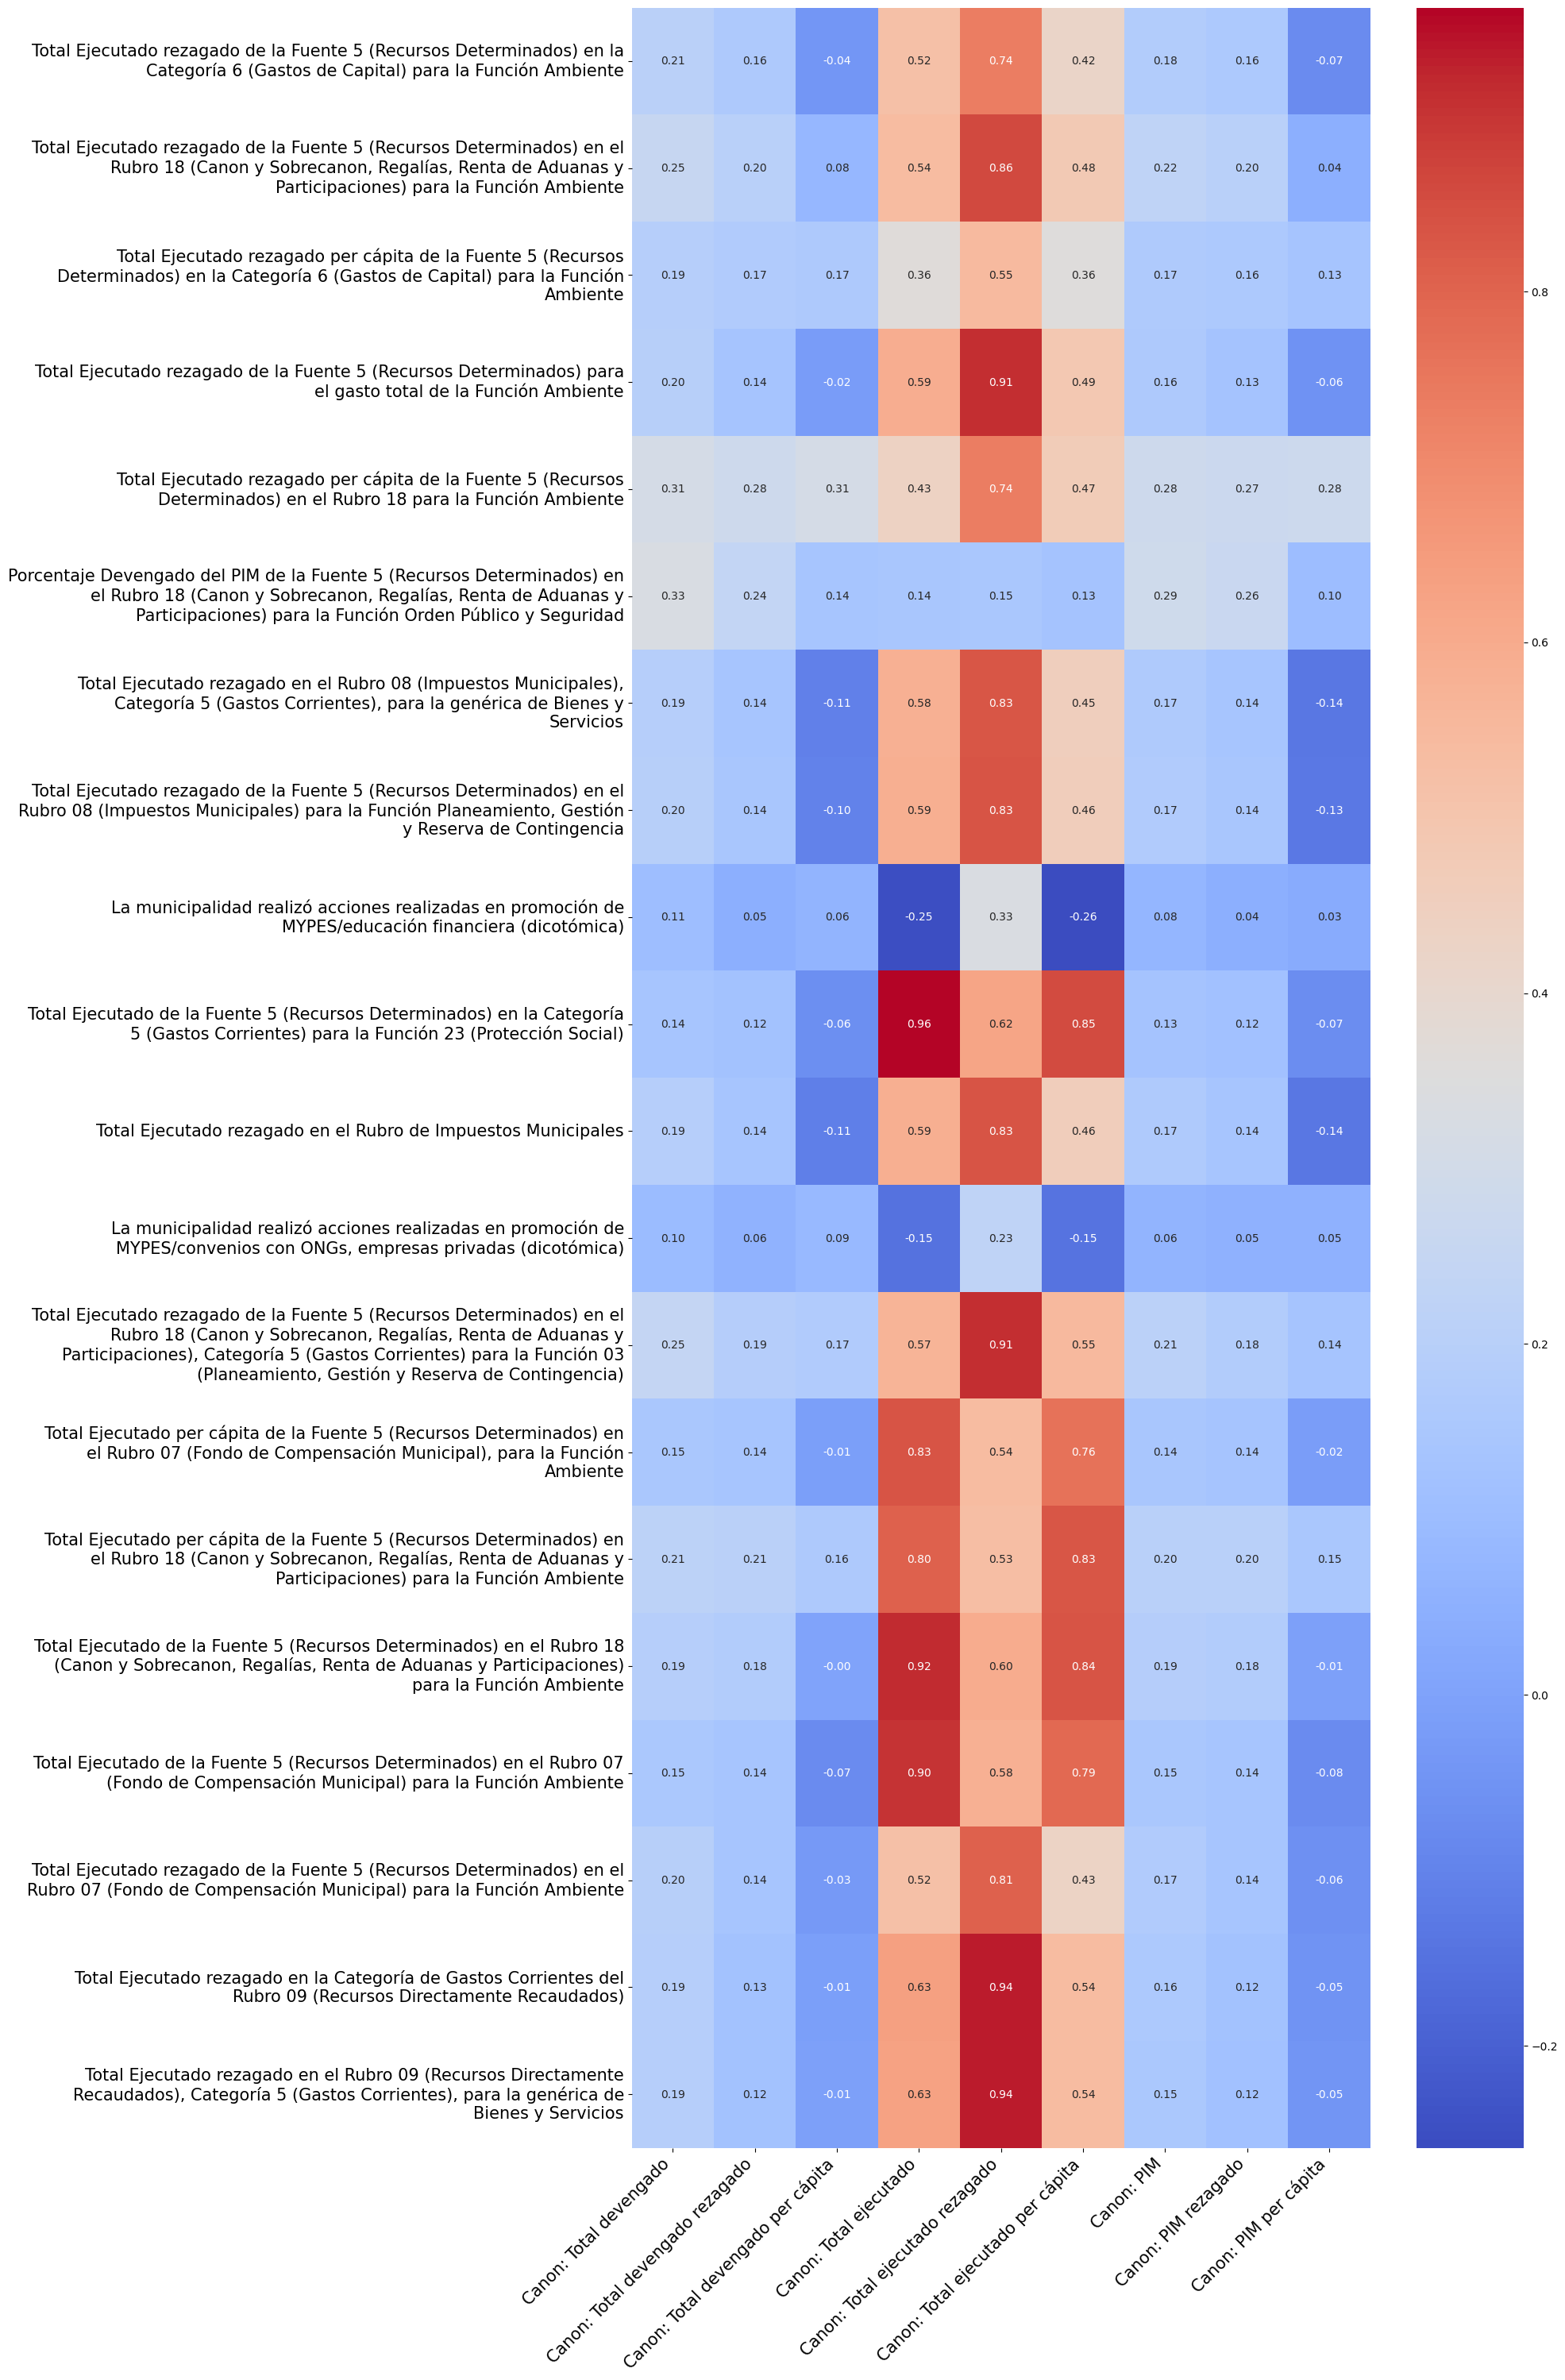

In [49]:
# Asumiendo que data es tu DataFrame y que has definido most_important_vars_ci y canon_vars
df_subset = data[most_important_vars_ci_shap + canon_vars]
correlation_matrix = df_subset.corr()
correlation_matrix_subset = correlation_matrix.loc[most_important_vars_ci_shap, canon_vars]

# Envolver (wrap) los nombres de las variables
wrapped_most_important_vars_ci_shap = [textwrap.fill(name, width=70) for name in most_important_vars_ci_shap]
wrapped_canon_vars = [textwrap.fill(name, width=50) for name in canon_vars]

plt.figure(figsize=(15, 35))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=wrapped_canon_vars,
            yticklabels=wrapped_most_important_vars_ci_shap)
# plt.title('Correlación entre las 20 primeras variables y las variables de Canon (Gini)', fontsize=18, fontweight='bold')

# Rotar las etiquetas si es necesario
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)

plt.savefig(f'../../../output/ejecucion_10/plots/ci_correlation_matrix_shap.jpg',
            format='jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## 2.2. BROAD CORRUPTION

### 2.2.1. Gini Criteria

In [19]:
path = r'..\..\..\input\preprocessed_data\base0.csv'
data = pd.read_csv( path )

In [20]:
data = data.rename( columns = { 'totaldev_canon'  : 'Canon: Total devengado', 
                                '_totaldev_canon' : 'Canon: Total devengado rezagado',
                                'totaldev_canonpc': 'Canon: Total devengado per cápita',
                                'totaleje_canon'  : 'Canon: Total ejecutado',
                                '_totaleje_canon' : 'Canon: Total ejecutado rezagado',
                                'totaleje_canonpc': 'Canon: Total ejecutado per cápita',
                                'pim_canon'       : 'Canon: PIM',
                                '_pim_canon': 'Canon: PIM rezagado',
                                'pim_canonpc': 'Canon: PIM per cápita' } )


variable_labels = {
    "tejgct_r00gstcr": "Total Ejecutado en la Categoría de Gastos Corrientes del Rubro 00 (Recursos Ordinarios)",
    "tejgfun_f5r18ct05vivpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgtotfun_f5amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 17 (Ambiente)",
    "tejgfun_f5ct05pgrco": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "_piagge_r08ct05biser": "Presupuesto Institucional de Apertura rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "tejgfun_f5ct05amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados), en la Categoría 5 (Gastos Corrientes) para la Función 17 (Ambiente)",
    "_piagtotfun_f2opsegpc": "Presupuesto Institucional de Apertura rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 05 (Orden Público y Seguridad)",
    "tejgfun_f5r08ct05ambpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función 17 (Ambiente)",
    "_tejgfun_f2ct05opseg": "Total Ejecutado rezagado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "tejgft_rdet": "Total Ejecutado en la fuente Recursos Determinados",
    "_tejgfun_f2ct05pgrco": "Total Ejecutado rezagado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "devppimtotfun_f5agropc": "Porcentaje Devengado per cápita del PIM de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 10 (Agropecuaria)",
    "tejgfun_f2ct05prots": "Total Ejecutado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "tejgfun_f5ct05prots": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "tejgfun_f2ct05viv": "Total Ejecutado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgtotfun_f5pgrco": "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "tejgfun_f5r18ct05cydep": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función de Cultura y Deporte",
    "_piagct_r08gstcr": "Presupuesto Institucional de Apertura rezagado en la Categoría de Gastos Corrientes del Rubro 08 (Impuestos Municipales)",
    "tejgfun_f2ct05pgrco": "Total Ejecutado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "devppimtotfun_f5r08agropc": "Porcentaje Devengado per cápita del PIM de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función 10 (Agropecuaria)"
}

most_important_vars_ca = [
    "Total Ejecutado en la Categoría de Gastos Corrientes del Rubro 00 (Recursos Ordinarios)",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 17 (Ambiente)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "Presupuesto Institucional de Apertura rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados), en la Categoría 5 (Gastos Corrientes) para la Función 17 (Ambiente)",
    "Presupuesto Institucional de Apertura rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función 05 (Orden Público y Seguridad)",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función 17 (Ambiente)",
    "Total Ejecutado rezagado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "Total Ejecutado en la fuente Recursos Determinados",
    "Total Ejecutado rezagado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "Porcentaje Devengado per cápita del PIM de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 10 (Agropecuaria)",
    "Total Ejecutado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "Total Ejecutado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función de Cultura y Deporte",
    "Presupuesto Institucional de Apertura rezagado en la Categoría de Gastos Corrientes del Rubro 08 (Impuestos Municipales)",
    "Total Ejecutado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "Porcentaje Devengado per cápita del PIM de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para el gasto total de la Función 10 (Agropecuaria)"
]


data = data.rename(columns={var: variable_labels[var] for var in data.columns if var in variable_labels})

canon_vars          = [ 'Canon: Total devengado', 'Canon: Total devengado rezagado', 'Canon: Total devengado per cápita', 
                        'Canon: Total ejecutado', 'Canon: Total ejecutado rezagado', 'Canon: Total ejecutado per cápita',
                        'Canon: PIM', 'Canon: PIM rezagado', 'Canon: PIM per cápita' ]

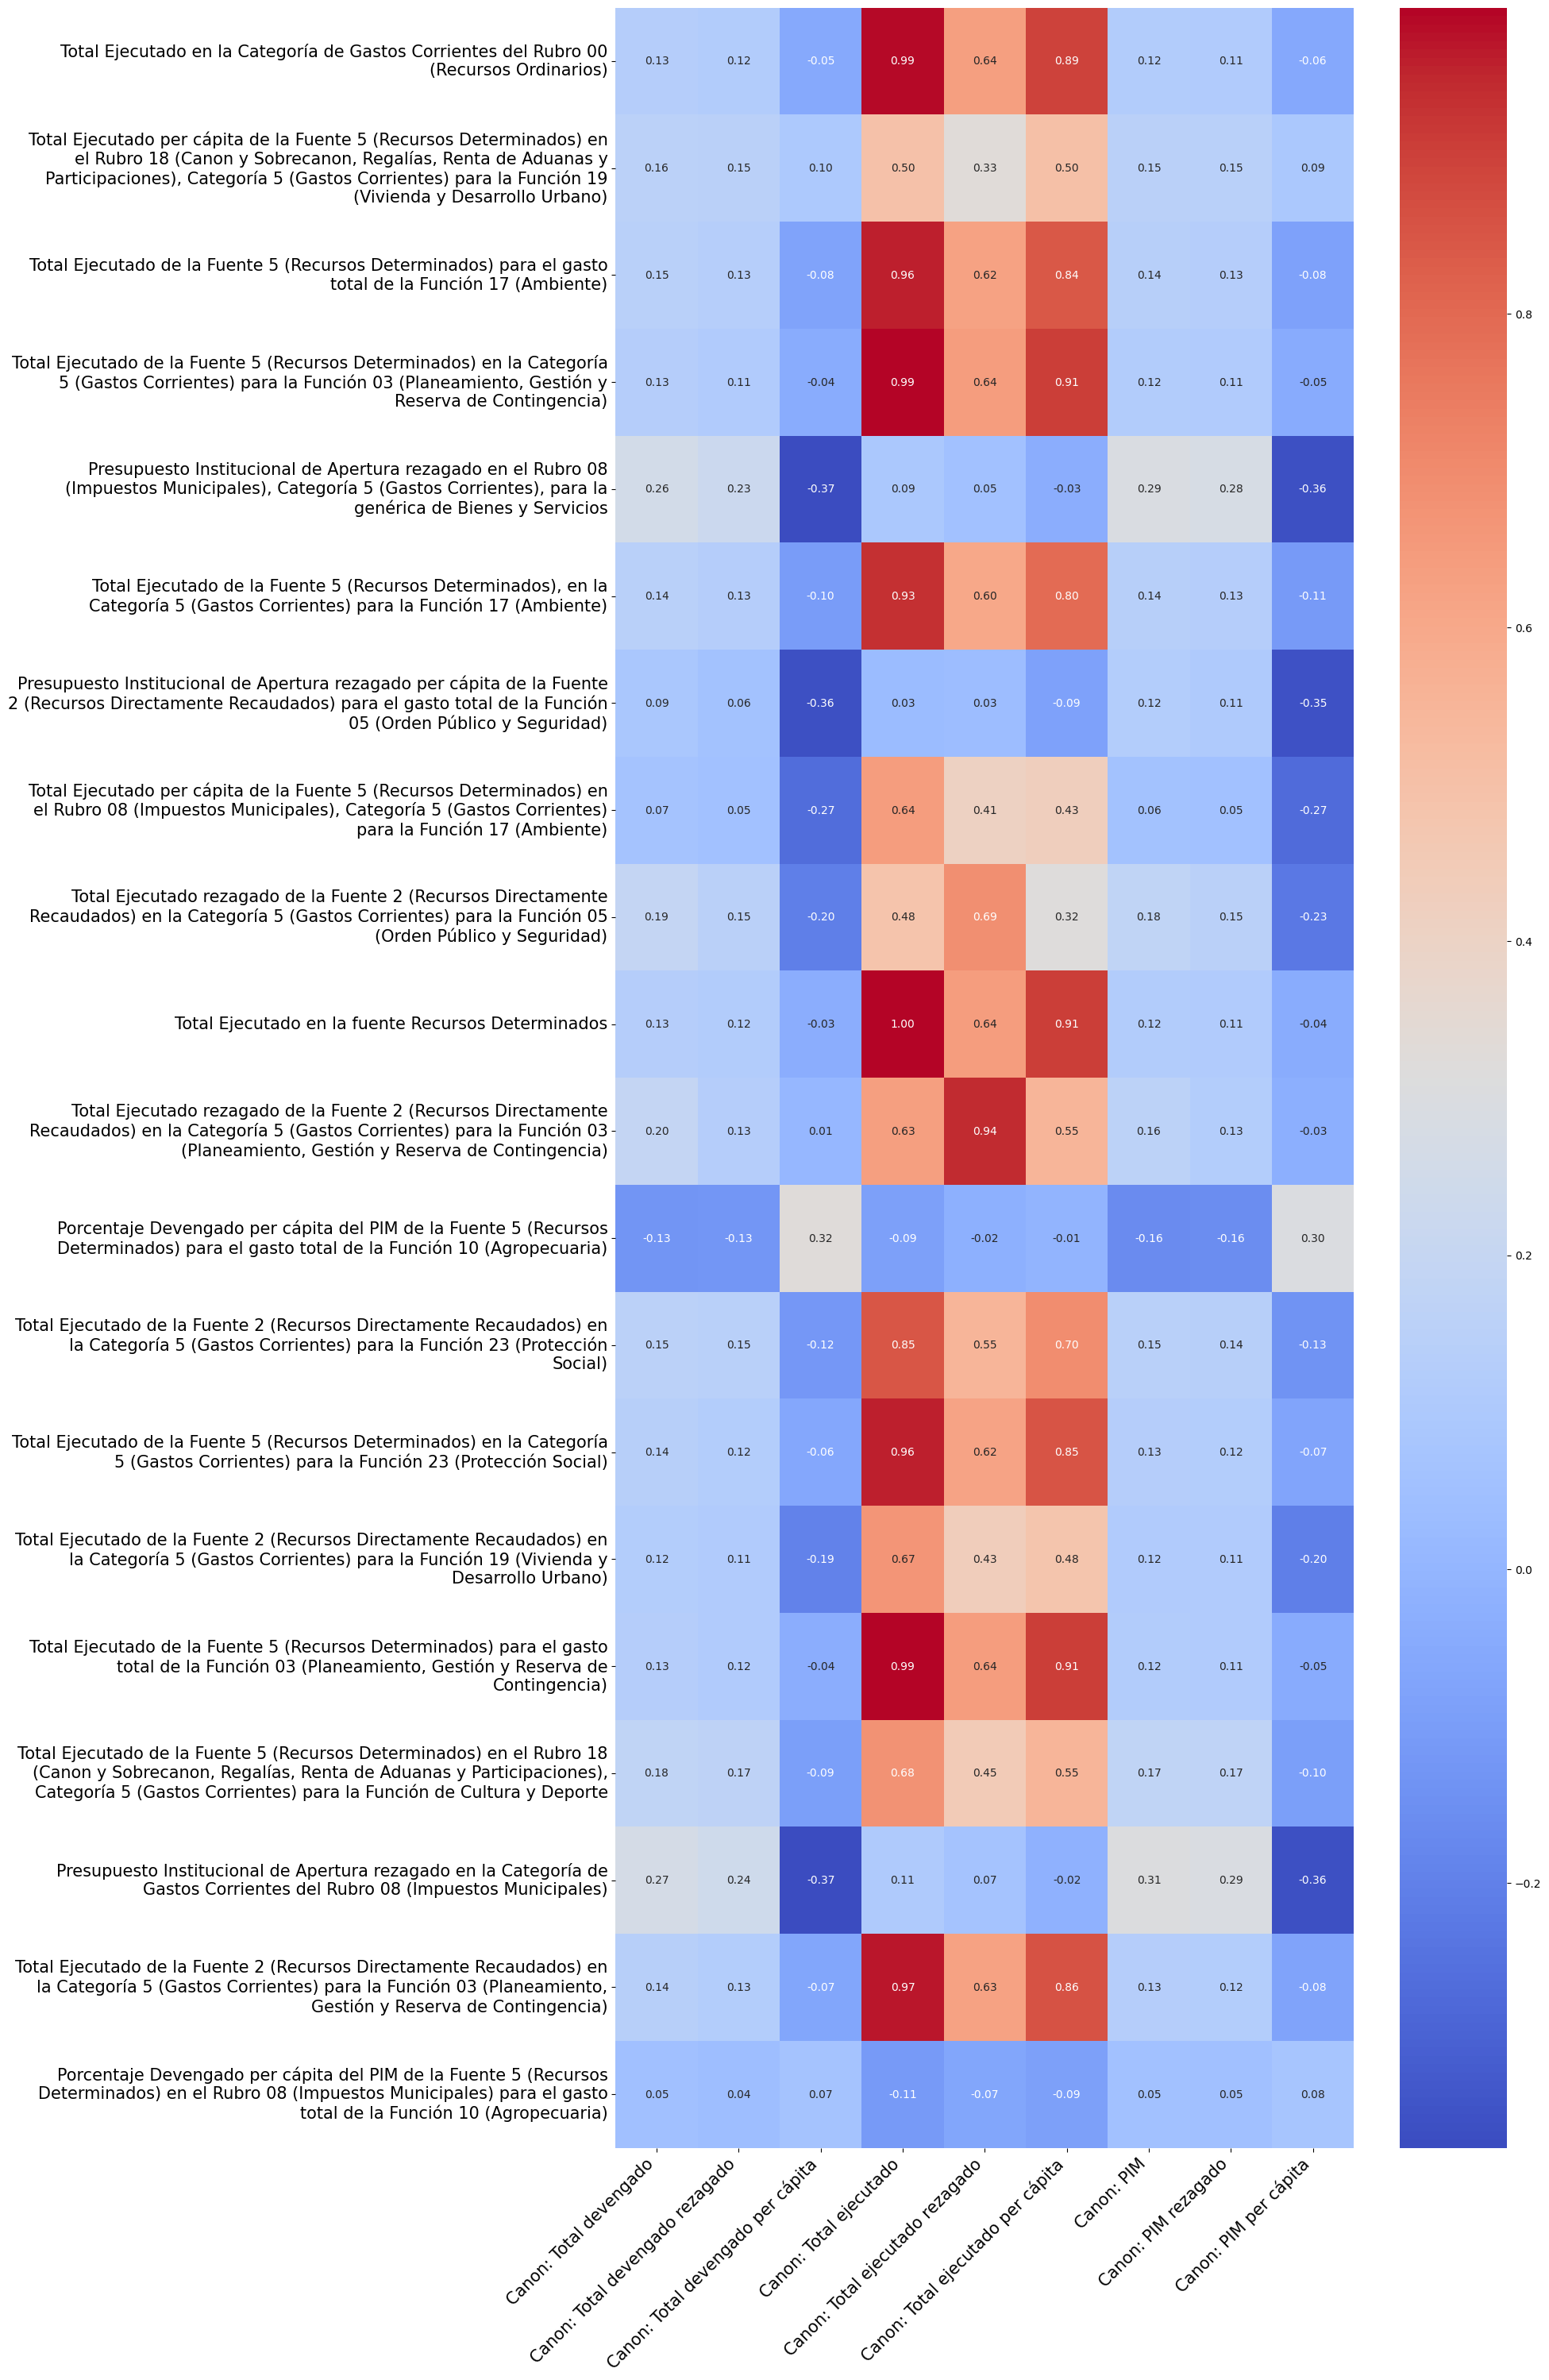

In [21]:
# Asumiendo que data es tu DataFrame y que has definido most_important_vars_ca y canon_vars
df_subset = data[most_important_vars_ca + canon_vars]
correlation_matrix = df_subset.corr()
correlation_matrix_subset = correlation_matrix.loc[most_important_vars_ca, canon_vars]

# Envolver (wrap) los nombres de las variables
wrapped_most_important_vars_ca = [textwrap.fill(name, width=70) for name in most_important_vars_ca]
wrapped_canon_vars = [textwrap.fill(name, width=50) for name in canon_vars]

plt.figure(figsize=(15, 35))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=wrapped_canon_vars,
            yticklabels=wrapped_most_important_vars_ca)
# plt.title('Correlación entre las 20 primeras variables y las variables de Canon (Gini)', fontsize=18, fontweight='bold')

# Rotar las etiquetas si es necesario
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)

plt.savefig(f'../../../output/ejecucion_10/plots/ca_correlation_matrix_gini.jpg',
            format='jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### 2.2.2. Correlation by SHAP Values

In [22]:
path = r'..\..\..\input\preprocessed_data\base0.csv'
data = pd.read_csv( path )

In [23]:
data = data.rename( columns = { 'totaldev_canon'  : 'Canon: Total devengado', 
                                '_totaldev_canon' : 'Canon: Total devengado rezagado',
                                'totaldev_canonpc': 'Canon: Total devengado per cápita',
                                'totaleje_canon'  : 'Canon: Total ejecutado',
                                '_totaleje_canon' : 'Canon: Total ejecutado rezagado',
                                'totaleje_canonpc': 'Canon: Total ejecutado per cápita',
                                'pim_canon'       : 'Canon: PIM',
                                '_pim_canon': 'Canon: PIM rezagado',
                                'pim_canonpc': 'Canon: PIM per cápita' } )

# Definiendo el mapeo de nombres originales a etiquetas para las tres variables
variable_labels = {
    "tejgct_r00gstcr": "Total Ejecutado en la Categoría de Gastos Corrientes del Rubro 00 (Recursos Ordinarios)",
    "tejgfun_f5r18ct05vivpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgtotfun_f5amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función Ambiente",
    "tejgfun_f5ct05pgrco": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "_piagtotfun_f2opsegpc": "Presupuesto Institucional de Apertura rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para la Función 05 (Orden Público y Seguridad)",
    "tejgfun_f5ct05amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función Ambiente",
    "_devppimtotfun_f2cydeppc": "Porcentaje Devengado rezagado per cápita del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función de Cultura y Deporte",
    "_devppimtotfun_f2cydep": "Porcentaje Devengado rezagado del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función de Cultura y Deporte",
    "dfgpimpiatotfun_f5r18cydep": "Diferencia entre el PIM y el PIA del gasto total de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función de Cultura y Deporte",
    "_piagge_r08ct05biser": "Presupuesto Institucional de Apertura rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "tejgfun_f5r08ct05ambpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función Ambiente",
    "_tejgfun_f2ct05opseg": "Total Ejecutado rezagado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "dfgpimpiafun_f2ct05opseg": "Diferencia entre el PIM y el PIA del gasto en la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "dfgdevpiagfun_f2ct05opseg": "Diferencia entre el Total Devengado y el PIA del gasto en la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "tejgft_rdet": "Total Ejecutado en la fuente Recursos Determinados",
    "_piagtotfun_f5r18amb": "Presupuesto Institucional de Apertura rezagado del gasto total de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "_dfgdevpiagtotfun_f2opsegpc": "Diferencia rezagada per cápita entre el Total Devengado y el PIA del gasto total de la Fuente 2 (Recursos Directamente Recaudados) para la Función 05 (Orden Público y Seguridad)",
    "devppimtotfun_f5agropc": "Porcentaje Devengado per cápita del PIM del gasto total de la Fuente 5 (Recursos Determinados) para la Función 10 (Agropecuaria)",
    "dfgdevpiagtotfun_f2opseg": "Diferencia entre el Total Devengado y el PIA del gasto total de la Fuente 2 (Recursos Directamente Recaudados) para la Función 05 (Orden Público y Seguridad)",
    "_tejgfun_f2ct05pgrco": "Total Ejecutado rezagado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)"
}


# Renombrando solo las columnas que están en el mapeo
data = data.rename(columns={var: variable_labels[var] for var in data.columns if var in variable_labels})

most_important_vars_ca_shap = [
    "Total Ejecutado en la Categoría de Gastos Corrientes del Rubro 00 (Recursos Ordinarios)",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función Ambiente",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "Presupuesto Institucional de Apertura rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para la Función 05 (Orden Público y Seguridad)",
    "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función Ambiente",
    "Porcentaje Devengado rezagado per cápita del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función de Cultura y Deporte",
    "Porcentaje Devengado rezagado del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función de Cultura y Deporte",
    "Diferencia entre el PIM y el PIA del gasto total de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función de Cultura y Deporte",
    "Presupuesto Institucional de Apertura rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función Ambiente",
    "Total Ejecutado rezagado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "Diferencia entre el PIM y el PIA del gasto en la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "Diferencia entre el Total Devengado y el PIA del gasto en la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "Total Ejecutado en la fuente Recursos Determinados",
    "Presupuesto Institucional de Apertura rezagado del gasto total de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "Diferencia rezagada per cápita entre el Total Devengado y el PIA del gasto total de la Fuente 2 (Recursos Directamente Recaudados) para la Función 05 (Orden Público y Seguridad)",
    "Porcentaje Devengado per cápita del PIM del gasto total de la Fuente 5 (Recursos Determinados) para la Función 10 (Agropecuaria)",
    "Diferencia entre el Total Devengado y el PIA del gasto total de la Fuente 2 (Recursos Directamente Recaudados) para la Función 05 (Orden Público y Seguridad)",
    "Total Ejecutado rezagado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)"
]


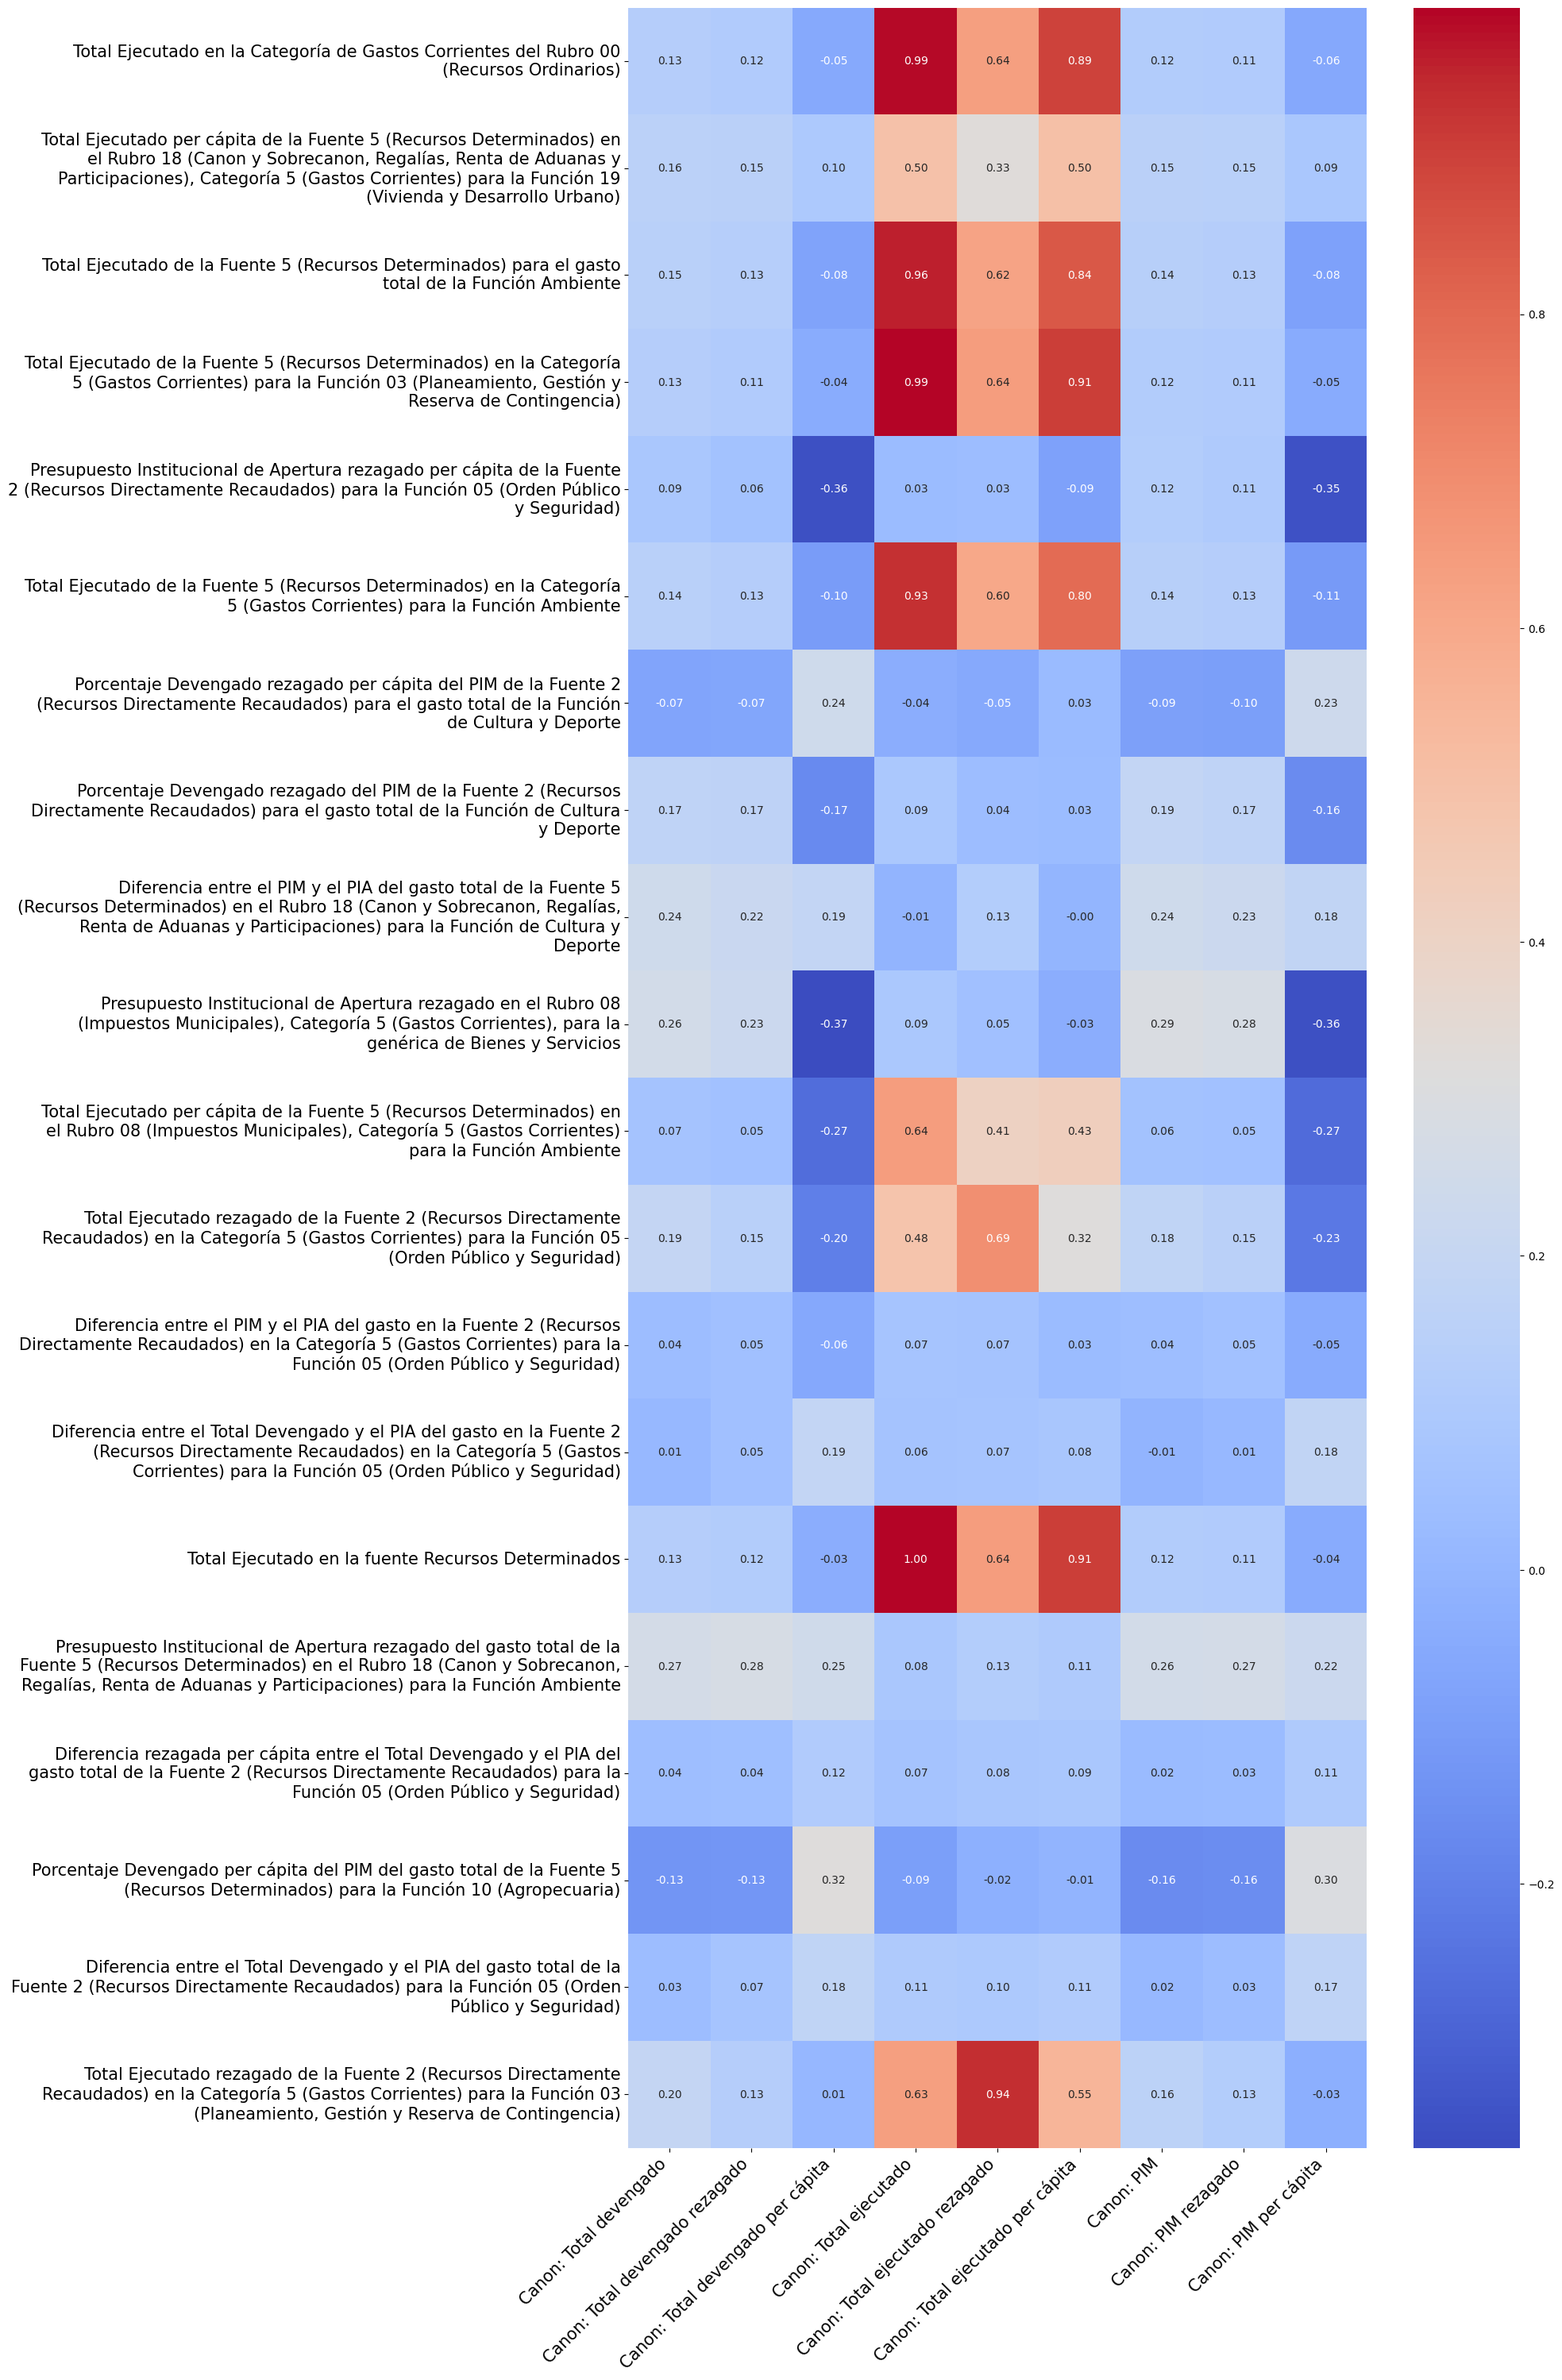

In [24]:
# Asumiendo que data es tu DataFrame y que has definido most_important_vars_ca_shap y canon_vars
df_subset = data[most_important_vars_ca_shap + canon_vars]
correlation_matrix = df_subset.corr()
correlation_matrix_subset = correlation_matrix.loc[most_important_vars_ca_shap, canon_vars]

# Envolver (wrap) los nombres de las variables
wrapped_most_important_vars_ca_shap = [textwrap.fill(name, width=70) for name in most_important_vars_ca_shap]
wrapped_canon_vars = [textwrap.fill(name, width=50) for name in canon_vars]

plt.figure(figsize=(15, 35))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=wrapped_canon_vars,
            yticklabels=wrapped_most_important_vars_ca_shap)
# plt.title('Correlación entre las 20 primeras variables y las variables de Canon (Gini)', fontsize=18, fontweight='bold')

# Rotar las etiquetas si es necesario
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)

plt.savefig(f'../../../output/ejecucion_10/plots/ca_correlation_matrix_shap.jpg',
            format='jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# 3. SHAP Values

### 3.1. Intense Corruption

In [25]:
path = r'..\..\..\input\preprocessed_data\base0.csv'
data = pd.read_csv( path )

In [26]:
dep_var    = [ 'corrup_intensa' ]
other_vars = [ 'monto_examinado', 'monto_auditado', 'monto_objeto_servicio',
               'monto_corrup1', 'monto_corrup2', 'tipo_control', 'corrup_amplia',
               'per_corrup1', 'per_corrup2', '_monto', 'monto_', 'year', 'ubigeo' ]

pred_vars  = [ col for col in data.columns if col not in dep_var and col not in other_vars ]

x_train, x_test, y_train, y_test = train_test_split( data[ pred_vars ],
                                                     data[ 'corrup_intensa' ],
                                                     test_size    = 0.3,
                                                     random_state = 2023,
                                                     stratify = data[ 'corrup_intensa' ] )

In [28]:
x_train_s, x_train_st, x_train_nro, y_train_s, y_train_st, y_train_nro = fun.resampling( x_train, y_train )

In [32]:
loaded_model = RandomForestClassifier( random_state = 2023, n_jobs = -1, n_estimators = 500, max_depth = 30, max_features = 2904 )
loaded_model.fit(x_train_s, y_train_s)

RandomForestClassifier(max_depth=30, max_features=2904, n_estimators=500,
                       n_jobs=-1, random_state=2023)

In [33]:
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(x_train_st, approximate=False, check_additivity=False)

In [34]:
shap_sum = np.abs(shap_values[0]).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': x_train_s.columns,
    'SHAP Value': shap_sum
})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Value', ascending=False)
feature_importance_df.to_excel(r'..\..\..\output\ejecucion_10\vars\shap_varlist_ci_Random Forest Classifier_s.xlsx')

In [50]:
name_mapping = {
    "_tejgfun_f5ct06amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función Ambiente",
    "_tejgtotfun_f5r18amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "_tejgfun_f5ct06ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en la Categoría 6 (Gastos de Capital) para la Función Ambiente",
    "_tejgtotfun_f5amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función Ambiente",
    "_tejgtotfun_f5r18ambpc": "Total Ejecutado rezagado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 para la Función Ambiente",
    "devppimtotfun_f5r18opseg": "Porcentaje Devengado del PIM de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Orden Público y Seguridad",
    "_tejgge_r08ct05biser": "Total Ejecutado rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "_tejgtotfun_f5r08pgrco": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales) para la Función Planeamiento, Gestión y Reserva de Contingencia",
    "empinc_7": "La municipalidad realizó acciones realizadas en promoción de MYPES/educación financiera (dicotómica)",
    "tejgfun_f5ct05prots": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 23 (Protección Social)",
    "_tejgrb_impm": "Total Ejecutado rezagado en el Rubro de Impuestos Municipales",
    "empinc_4": "La municipalidad realizó acciones realizadas en promoción de MYPES/convenios con ONGs, empresas privadas (dicotómica)",
    "_tejgfun_f5r18ct05pgrco": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "tejgtotfun_f5r07ambpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal), para la Función Ambiente",
    "tejgtotfun_f5r18ambpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "tejgtotfun_f5r18amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "tejgtotfun_f5r07amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Función Ambiente",
    "_tejgtotfun_f5r07amb": "Total Ejecutado rezagado de la Fuente 5 (Recursos Determinados) en el Rubro 07 (Fondo de Compensación Municipal) para la Función Ambiente",
    "_tejgct_r09gstcr": "Total Ejecutado rezagado en la Categoría de Gastos Corrientes del Rubro 09 (Recursos Directamente Recaudados)",
    "_tejgge_r09ct05biser": "Total Ejecutado rezagado en el Rubro 09 (Recursos Directamente Recaudados), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios"
}

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


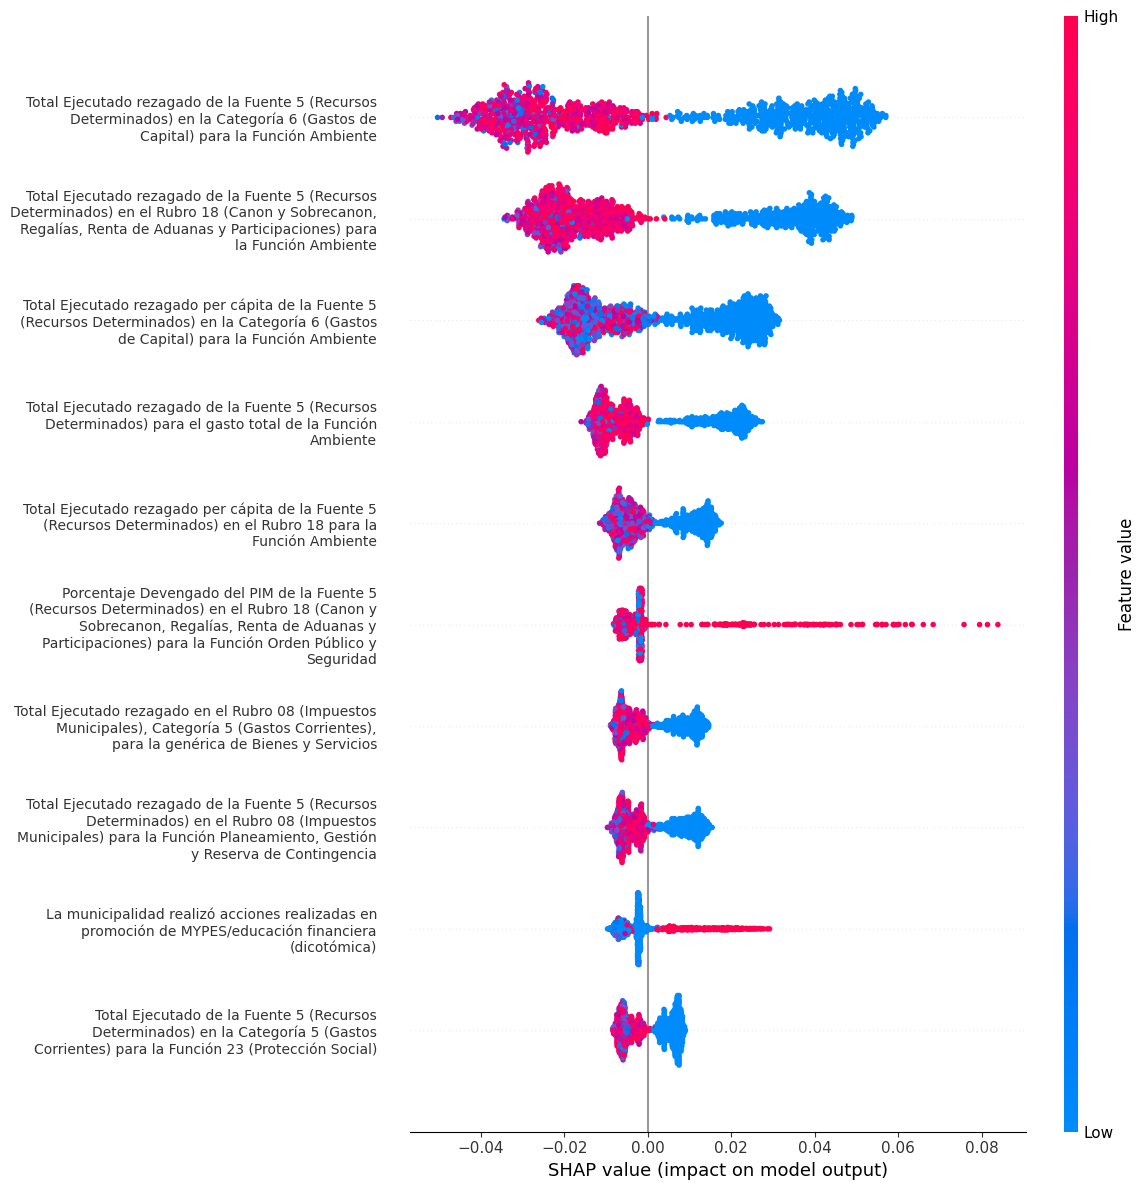

In [51]:
# Clase que se desea predecir
class_index = 1

# Variables wrapped
wrapped_feature_names = [textwrap.fill(name_mapping[name], width=50) if name in name_mapping else name for name in x_train_st.columns]
# wrapped_feature_names = [textwrap.fill(name, width=40) for name in x_train_st.columns]

# Asumiendo que shap_values ya ha sido calculado y que class_index está definido
shap_sum = np.abs(shap_values[class_index]).mean(axis=0)

# Obtener los índices de las 10 características más importantes
top_indices = np.argsort(shap_sum)[-10:]

# Si x_train es un DataFrame, usa .iloc para indexar por posición
x_train_top = x_train_st.iloc[:, top_indices]

# Filtrar feature_names para quedarnos solo con las 10 características más importantes
feature_names_top = [wrapped_feature_names[i] for i in top_indices]

# Graficar los valores SHAP para las 10 características más importantes
shap.summary_plot(shap_values[class_index][:, top_indices], x_train_top, 
                  feature_names=feature_names_top, 
                  show=False,
                  plot_size=(12, 12))

plt.yticks(fontsize=10)
plt.tight_layout()  # Ajusta la disposición de la trama
# plt.title('Top 10 SHAP Value Features for Positive Corruption Cases',
        #   fontsize = 18, fontweight = 'bold' )
plt.savefig('../../../output/ejecucion_10/plots/ci_shap_features.jpg', bbox_inches='tight')  # Guarda el gráfico
plt.show()

### 3.2. Broad Corruption

In [8]:
path = r'..\..\..\input\preprocessed_data\base0.csv'
data = pd.read_csv( path )

In [9]:
dep_var    = [ 'corrup_amplia' ]
other_vars = [ 'monto_examinado', 'monto_auditado', 'monto_objeto_servicio',
               'monto_corrup1', 'monto_corrup2', 'tipo_control', 'corrup_intensa',
               'per_corrup1', 'per_corrup2', '_monto', 'monto_', 'year', 'ubigeo' ]

pred_vars  = [ col for col in data.columns if col not in dep_var and col not in other_vars ]

x_train, x_test, y_train, y_test = train_test_split( data[ pred_vars ],
                                                     data[ 'corrup_amplia' ],
                                                     test_size    = 0.3,
                                                     random_state = 2023,
                                                     stratify = data[ 'corrup_amplia' ] )

In [10]:
x_train_s, x_train_st, x_train_nro, y_train_s, y_train_st, y_train_nro = fun.resampling( x_train, y_train )

In [11]:
# path         = r'..\..\..\output\ejecucion_8\models\model_ca_Regression Forest_s.joblib'
# loaded_model = joblib.load( path )
reg_forest_nro_model = RegressionForest( random_state = 2023, n_jobs = -1, n_estimators = 1000, max_depth = 30 )
reg_forest_nro_model.fit(x_train_nro, y_train_nro)

RegressionForest(max_depth=30, n_estimators=1000, random_state=2023)

In [12]:
explainer = shap.TreeExplainer(reg_forest_nro_model)
shap_values = explainer.shap_values(x_train_nro, approximate=False, check_additivity=False)

In [16]:
shap_sum = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': x_train_nro.columns,
    'SHAP Value': shap_sum
})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Value', ascending=False)
feature_importance_df.to_excel(r'..\..\..\output\ejecucion_10\vars\shap_varlist_ca_Regression Forest_nro.xlsx')
feature_importance_df

Feature  SHAP Value
303                 tejgct_r00gstcr    0.019887
8991         tejgfun_f5r18ct05vivpc    0.015642
3790               tejgtotfun_f5amb    0.013285
1663            tejgfun_f5ct05pgrco    0.012350
11644         _piagtotfun_f2opsegpc    0.008487
...                             ...         ...
9873       devppimfun_f3ct06saludpc    0.000000
9872    dfgdevpiagfun_f3ct06saludpc    0.000000
9871     dfgpimpiafun_f3ct06saludpc    0.000000
5850   _dfgdevpiagfun_f5r08ct06comu    0.000000
8823       tdvgfun_f5r07ct05energpc    0.000000

[14520 rows x 2 columns]

In [17]:
name_mapping = {
    "tejgct_r00gstcr": "Total Ejecutado en la Categoría de Gastos Corrientes del Rubro 00 (Recursos Ordinarios)",
    "tejgfun_f5r18ct05vivpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones), Categoría 5 (Gastos Corrientes) para la Función 19 (Vivienda y Desarrollo Urbano)",
    "tejgtotfun_f5amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) para el gasto total de la Función Ambiente",
    "tejgfun_f5ct05pgrco": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)",
    "_piagtotfun_f2opsegpc": "Presupuesto Institucional de Apertura rezagado per cápita de la Fuente 2 (Recursos Directamente Recaudados) para la Función 05 (Orden Público y Seguridad)",
    "tejgfun_f5ct05amb": "Total Ejecutado de la Fuente 5 (Recursos Determinados) en la Categoría 5 (Gastos Corrientes) para la Función Ambiente",
    "_devppimtotfun_f2cydeppc": "Porcentaje Devengado rezagado per cápita del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función de Cultura y Deporte",
    "_devppimtotfun_f2cydep": "Porcentaje Devengado rezagado del PIM de la Fuente 2 (Recursos Directamente Recaudados) para el gasto total de la Función de Cultura y Deporte",
    "dfgpimpiatotfun_f5r18cydep": "Diferencia entre el PIM y el PIA del gasto total de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función de Cultura y Deporte",
    "_piagge_r08ct05biser": "Presupuesto Institucional de Apertura rezagado en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes), para la genérica de Bienes y Servicios",
    "tejgfun_f5r08ct05ambpc": "Total Ejecutado per cápita de la Fuente 5 (Recursos Determinados) en el Rubro 08 (Impuestos Municipales), Categoría 5 (Gastos Corrientes) para la Función Ambiente",
    "_tejgfun_f2ct05opseg": "Total Ejecutado rezagado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "dfgpimpiafun_f2ct05opseg": "Diferencia entre el PIM y el PIA del gasto en la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "dfgdevpiagfun_f2ct05opseg": "Diferencia entre el Total Devengado y el PIA del gasto en la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 05 (Orden Público y Seguridad)",
    "tejgft_rdet": "Total Ejecutado en la fuente Recursos Determinados",
    "_piagtotfun_f5r18amb": "Presupuesto Institucional de Apertura rezagado del gasto total de la Fuente 5 (Recursos Determinados) en el Rubro 18 (Canon y Sobrecanon, Regalías, Renta de Aduanas y Participaciones) para la Función Ambiente",
    "_dfgdevpiagtotfun_f2opsegpc": "Diferencia rezagada per cápita entre el Total Devengado y el PIA del gasto total de la Fuente 2 (Recursos Directamente Recaudados) para la Función 05 (Orden Público y Seguridad)",
    "devppimtotfun_f5agropc": "Porcentaje Devengado per cápita del PIM del gasto total de la Fuente 5 (Recursos Determinados) para la Función 10 (Agropecuaria)",
    "dfgdevpiagtotfun_f2opseg": "Diferencia entre el Total Devengado y el PIA del gasto total de la Fuente 2 (Recursos Directamente Recaudados) para la Función 05 (Orden Público y Seguridad)",
    "_tejgfun_f2ct05pgrco": "Total Ejecutado rezagado de la Fuente 2 (Recursos Directamente Recaudados) en la Categoría 5 (Gastos Corrientes) para la Función 03 (Planeamiento, Gestión y Reserva de Contingencia)"
}


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


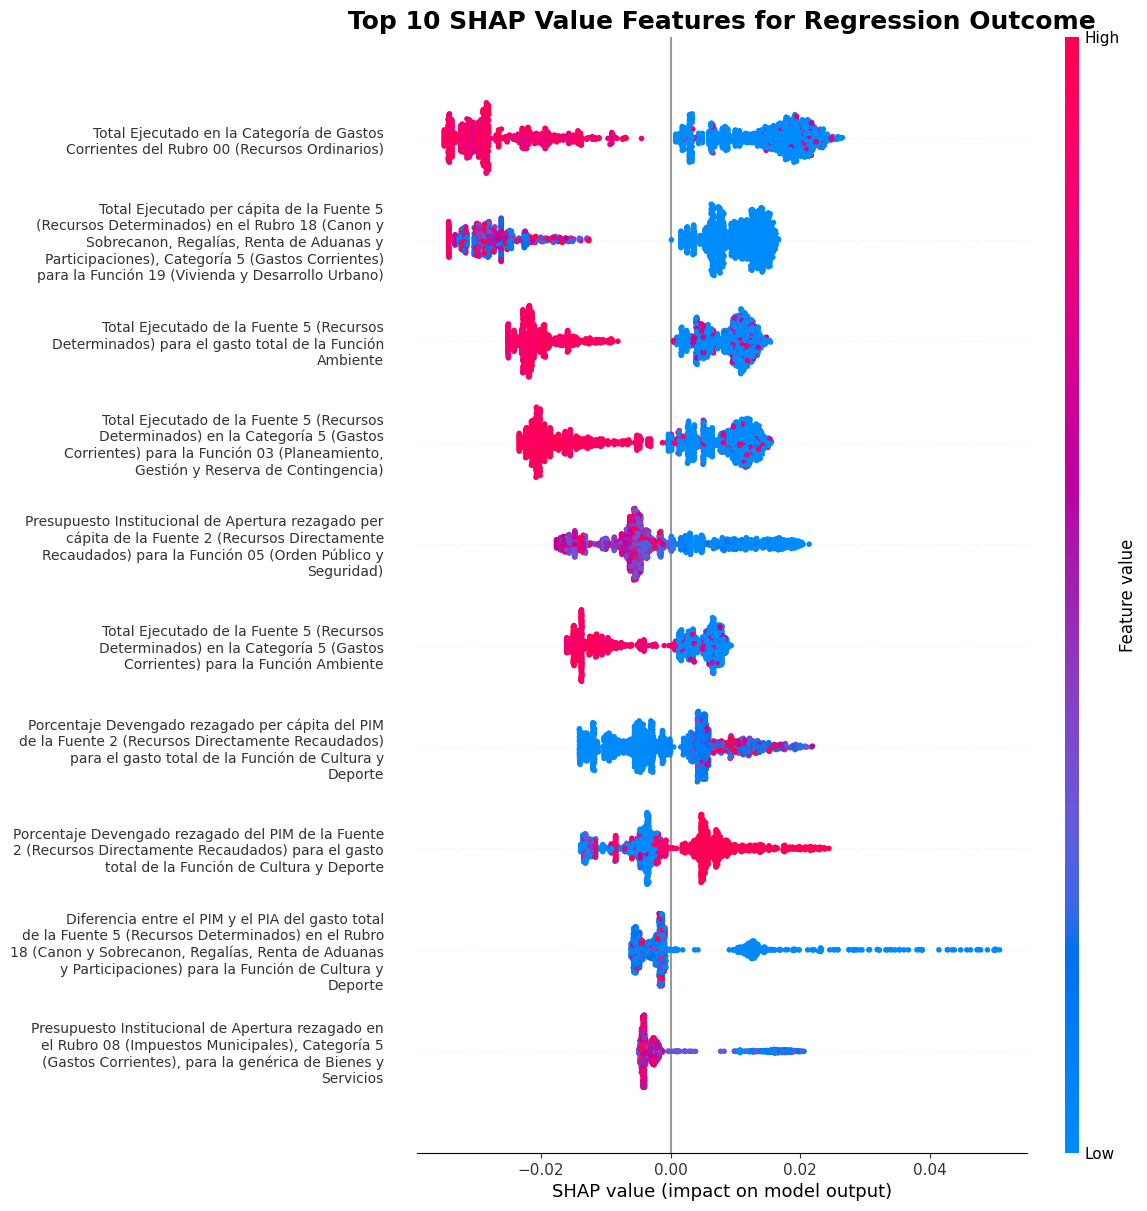

In [18]:
# Variables wrapped
wrapped_feature_names = [textwrap.fill(name_mapping[name], width=50) if name in name_mapping else name for name in x_train_nro.columns]

# Asumiendo que shap_values ya ha sido calculado para un modelo de regresión
shap_sum = np.abs(shap_values).mean(axis=0)

# Obtener los índices de las 10 características más importantes
top_indices = np.argsort(shap_sum)[-10:]

# Si x_train es un DataFrame, usa .iloc para indexar por posición
x_train_top = x_train_nro.iloc[:, top_indices]

# Filtrar feature_names para quedarnos solo con las 10 características más importantes
feature_names_top = [wrapped_feature_names[i] for i in top_indices]

# Graficar los valores SHAP para las 10 características más importantes
shap.summary_plot(shap_values[:, top_indices], x_train_top, 
                  feature_names=feature_names_top, 
                  show=False,
                  plot_size=(12, 12))

plt.yticks(fontsize=10)
plt.tight_layout()  # Ajusta la disposición de la trama
plt.title('Top 10 SHAP Value Features for Regression Outcome',
          fontsize = 18, fontweight = 'bold' )
plt.savefig('../../../output/ejecucion_10/plots/ca_shap_features.jpg', bbox_inches='tight')  # Guarda el gráfico
plt.show()

# 4. REGRESSION FOREST THESHOLDS

## 4.1. Intense corruption

In [19]:
df = pd.read_excel( r'..\..\..\output\ejecucion_10\results\base0_ci_regression_forest_0.5.xlsx')

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


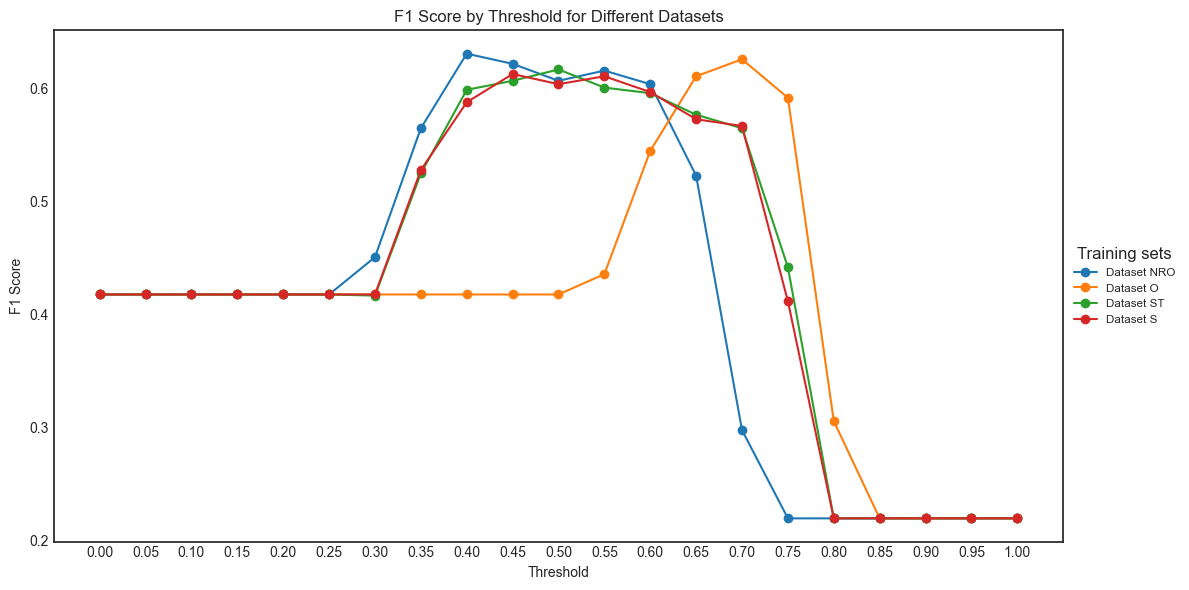

In [20]:
# Apply the modifications to the plotting code as requested
df[['Threshold', 'Method', 'Dataset']] = df['Model'].str.split('_', expand=True)

# Convert the threshold to numeric for plotting
df['Threshold'] = pd.to_numeric(df['Threshold'])

# Separate the dataframe by dataset
datasets = df['Dataset'].unique()
plot_data = {}

for dataset in datasets:
    dataset_df = df[df['Dataset'] == dataset]
    # Group by threshold to handle multiple runs with the same threshold, if any
    grouped = dataset_df.groupby('Threshold')['f1_test'].mean().reset_index()
    plot_data[dataset] = grouped

# Setting the style for the plot to be white background without grid
plt.style.use('seaborn-white')

# Plotting with modifications
plt.figure(figsize=(12, 6))

for dataset, data in plot_data.items():
    # Capitalize dataset name for the legend
    label = dataset.upper() if dataset in ['o', 's', 'st', 'nro'] else dataset
    plt.plot(data['Threshold'], data['f1_test'], marker='o', label=f"Dataset {label}")

plt.title('F1 Score by Threshold for Different Datasets')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.xticks(ticks=np.arange(0.0, 1.05, 0.05))

# Place legend outside the plot on the right side, at the middle
plt.legend(title='Training sets', loc='center left', bbox_to_anchor=(1, 0.5), title_fontsize='large', fontsize='small')

# Make layout tight to ensure the legend fits without overlapping
plt.tight_layout()

plt.savefig(r'..\..\..\output\ejecucion_10\plots\ci_reg_f_thresholds_0.5.png', bbox_inches='tight')
# Show plot
plt.show()

## 4.2. Broad corruption

In [21]:
df = pd.read_excel( r'..\..\..\output\ejecucion_10\results\base0_ca_regression_forest_0.5.xlsx')

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


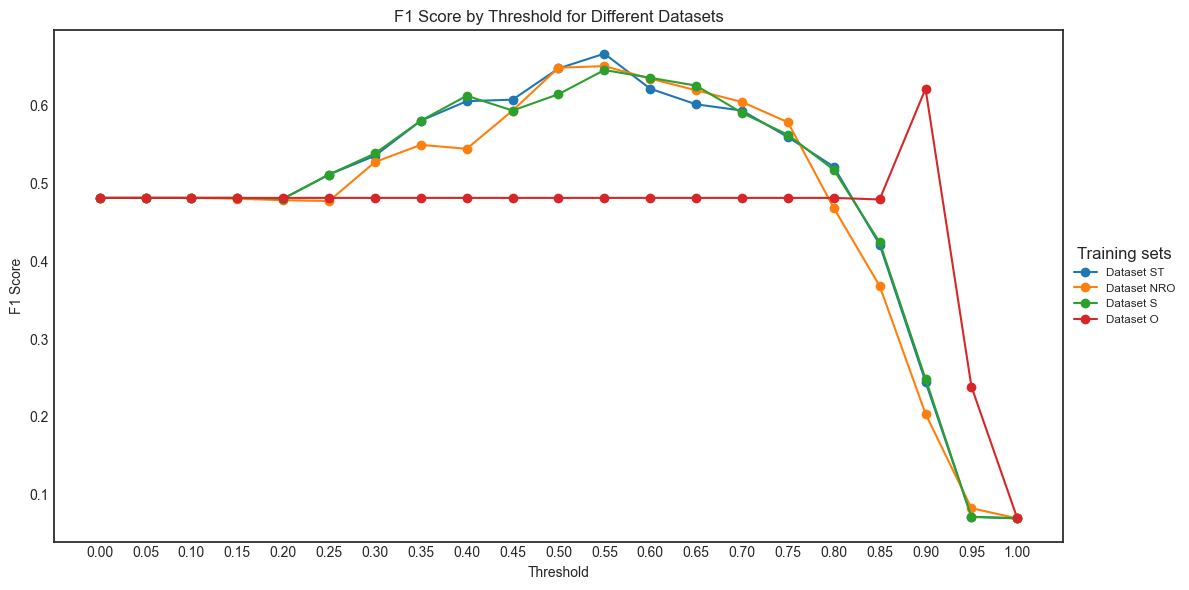

In [22]:
# Apply the modifications to the plotting code as requested
df[['Threshold', 'Method', 'Dataset']] = df['Model'].str.split('_', expand=True)

# Convert the threshold to numeric for plotting
df['Threshold'] = pd.to_numeric(df['Threshold'])

# Separate the dataframe by dataset
datasets = df['Dataset'].unique()
plot_data = {}

for dataset in datasets:
    dataset_df = df[df['Dataset'] == dataset]
    # Group by threshold to handle multiple runs with the same threshold, if any
    grouped = dataset_df.groupby('Threshold')['f1_test'].mean().reset_index()
    plot_data[dataset] = grouped

# Setting the style for the plot to be white background without grid
plt.style.use('seaborn-white')

# Plotting with modifications
plt.figure(figsize=(12, 6))

for dataset, data in plot_data.items():
    # Capitalize dataset name for the legend
    label = dataset.upper() if dataset in ['o', 's', 'st', 'nro'] else dataset
    plt.plot(data['Threshold'], data['f1_test'], marker='o', label=f"Dataset {label}")

plt.title('F1 Score by Threshold for Different Datasets')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.xticks(ticks=np.arange(0.0, 1.05, 0.05))

# Place legend outside the plot on the right side, at the middle
plt.legend(title='Training sets', loc='center left', bbox_to_anchor=(1, 0.5), title_fontsize='large', fontsize='small')

# Make layout tight to ensure the legend fits without overlapping
plt.tight_layout()

plt.savefig(r'..\..\..\output\ejecucion_10\plots\ca_reg_f_thresholds_0.5.png', bbox_inches='tight')
# Show plot
plt.show()